In [1]:
import argparse
import os
import time
import numba as nb
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random
from mpl_toolkits.mplot3d import Axes3D
import pylab 
import numpyro
import math
import sys
import time
from PIL import Image
sys.path.append('.')
sys.path.append('..')
from utils.utils import swill_roll_non_embed_f, swill_roll_non_embed_nuniform_f, swill_roll_line_non_embed_f, swill_roll_curve_non_embed_f
from Codes.Model_class import fill_diagonal, kernel_fromdists, predict_mean_fromdists
from sklearn.manifold import Isomap

In [2]:
%matplotlib inline
rng_key, rng_key_predict = random.split(random.PRNGKey(0))

In [3]:
def generate_figure_data(num = 72, obj_name = 'obj4__',file_path = '/Users/tt/Desktop/Git Codes/Research/Gp:Kernel Regression on Unknown Manifold/Data/coil-20-proc/'):
    data = np.zeros((num, 128,128))
    for figure_num in range(num):
        data[figure_num,:,:] = np.array(Image.open(file_path+ obj_name + str(figure_num) + '.png'))
    return data

In [4]:
lucky_cat_data = generate_figure_data()
f_0 = np.cos(2 * np.pi * np.arange(0,72)/72)

In [5]:
def cat_train_test(train_size = 18, sigma_noise = 0.1, f_0 = f_0):
    idx = np.arange(72)
    th = idx/72 * 2* np.pi
    np.random.shuffle(idx)
    train_idx, test_idx = idx[:train_size], idx[train_size:]
    
    
    X = lucky_cat_data[train_idx,:].reshape(train_size, -1)
    tX = th[train_idx]
    Y_train = f_0[train_idx]
    Y = Y_train + sigma_noise * np.random.randn(train_size)
    
    X_test = lucky_cat_data[test_idx,:].reshape(72-train_size, -1)
    tX_test = th[test_idx]
    Y_test = f_0[test_idx]
  
    return X, tX, X_test, tX_test,Y_train, Y ,Y_test

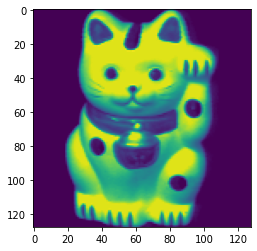

In [6]:
degrees = 90
#img = np.array(Image.open('emma_stone.jpg'))
# img = img.sum(2) / (255*3) # converting to grayscale
fig = plt.figure(figsize=(5, 4))

plt.imshow(lucky_cat_data[0,:,:])
#plt.title("original")


In [7]:
N_num = 3
ls_d_miss = [i for i in range(1,11)]
train_error_means=np.zeros((N_num,len(ls_d_miss)))
train_error_stds=np.zeros((N_num,len(ls_d_miss)))
test_error_means=np.zeros((N_num,len(ls_d_miss)))
test_error_stds=np.zeros((N_num,len(ls_d_miss)))
data_number = [18,36,54]
dict_num = {num:i for i, num in enumerate(data_number)}
post_means, post_std =np.zeros(N_num), np.zeros(N_num)
weighted_means, weighted_std = np.zeros(N_num), np.zeros(N_num)
w_likelihood_means, w_likelihood_std =np.zeros(N_num), np.zeros(N_num)
w_pos_means, w_pos_std =np.zeros(N_num), np.zeros(N_num)
w_pos_knn_means, w_pos_knn_std =np.zeros(N_num), np.zeros(N_num)
single_means, single_std=np.zeros(N_num), np.zeros(N_num)

post_test_means, post_test_std =np.zeros(N_num), np.zeros(N_num)
weighted_test_means, weighted_test_std =np.zeros(N_num), np.zeros(N_num)
w_pos_test_means, w_pos_test_std=np.zeros(N_num), np.zeros(N_num)
#post_means[dict_num[train_size]], post_std[dict_num[train_size]] =np.mean(ls_w_pos_miss_test), np.std(ls_w_pos_miss_test)
w_pos_knn_test_means, w_pos_knn_test_std =np.zeros(N_num), np.zeros(N_num)
iso_means, iso_std=np.zeros(N_num), np.zeros(N_num)
iso_test_means, iso_test_std=np.zeros(N_num), np.zeros(N_num)

In [8]:
shape = 2
sigmasq_0 = 0.01
replicas = 100
n_grid = 100
train_size = 18
n_data = 72
test_size = n_data - train_size
k_data= 3
k_data_max = math.ceil(train_size * 0.15)
k_nn_distance = np.zeros(replicas)
k_nn_distance_max =  np.zeros(replicas)
iso_knn_k = 10
k_size = math.ceil(train_size *0.2)


In [9]:
mcmc_time = 3000
burn_in = 1000

In [10]:
ls_epsilons = np.zeros((replicas, mcmc_time ))
log_likelihoods = np.zeros(mcmc_time)
log_pos = np.zeros(mcmc_time )
log_pos_miss = np.zeros((len(ls_d_miss),mcmc_time ))
log_pos_knn = np.zeros(mcmc_time )
ls_insample = np.zeros((replicas,n_grid))
ls_outsample = np.zeros((replicas,n_grid))
ls_insample_iso = np.zeros((replicas,n_grid))
ls_outsample_iso = np.zeros((replicas,n_grid))
ls_weighted = np.zeros(replicas)
ls_w_likelihood = np.zeros(replicas)
ls_w_pos = np.zeros(replicas)
ls_w_pos_miss = np.zeros((replicas, len(ls_d_miss)))
ls_single = np.zeros(replicas)
ls_w_pos_knn = np.zeros(replicas)
ls_weighted_test = np.zeros(replicas)
ls_w_likelihood_test = np.zeros(replicas)
ls_w_pos_test = np.zeros(replicas)
ls_w_pos_miss_test = np.zeros((replicas, len(ls_d_miss)))
#ls_single = np.zeros(replicas)
ls_w_pos_knn_test = np.zeros(replicas)
v_hat = np.zeros((replicas,mcmc_time))

In [11]:
#Choose sigma_proposal 
#Use grid posterior to look for range (can be rounded)
replica = 0
n_grid = 100
ls_grid_epsilon = np.linspace(10**-5, 1, n_grid)
log_grid_likelihoods = np.zeros(n_grid)
log_grid_pos = np.zeros(n_grid)
log_grid_pos_knn = np.zeros(n_grid)
X_train, tX_train, X_test, tX_test, Y_train, Y, Y_test = cat_train_test(train_size = train_size, sigma_noise = np.sqrt(sigmasq_0))
max_scale = np.max(np.linalg.norm(X_train,axis = 1))
X_train, X_test = X_train/max_scale, X_test/max_scale 
dists_XX = scipy.spatial.distance.cdist(X_train, X_train)
dists_pX = scipy.spatial.distance.cdist(X_test, X_train)
k_nn_subtable = np.sort(dists_XX[:k_size, :], axis = 1)
k_nn_distance[replica] = (np.mean(k_nn_subtable [:,k_data]))**2
k_nn_distance_max[replica] = (np.mean(k_nn_subtable [:,k_data_max]))**2
for i, epsilon in enumerate(ls_grid_epsilon):
    k_XX = kernel_fromdists(dists_XX, 1, epsilon, sigmasq_0, include_noise=True)
    k_pX = kernel_fromdists(dists_pX, 1, epsilon, sigmasq_0, include_noise=False)
    k_XX_de = kernel_fromdists(dists_XX, 1, epsilon, sigmasq_0, include_noise=False)
    hat_inverse = jnp.linalg.solve(k_XX, Y_train)
    log_grid_likelihoods[i] = -0.5 * jnp.matmul(Y_train, hat_inverse)
#         log_likelihoods[i] = -0.5 * jnp.matmul(Y_train, jnp.linalg.solve(k_XX, Y_train))
    log_grid_likelihoods[i] += -0.5 * jnp.linalg.slogdet(k_XX)[1]
    #log_pos[i] = log_likelihoods[i] + jnp.log(scipy.stats.invgamma.pdf(x =  epsilon, a = shape, scale = 1))
    #log_grid_pos[i] = log_grid_likelihoods[i] - 2 * np.log(epsilon) - 1/epsilon
    R_hat= (k_XX_de.sum(1)-1)/(k_XX_de.shape[1]-1)
    v_hat[replica,i] = np.mean(R_hat)
    log_grid_pos_knn[i] = log_grid_likelihoods[i] - 2 * np.log(epsilon) - 1/v_hat[replica,i]
weight_pos = np.exp(log_grid_pos - np.max(log_grid_pos))
weight_pos = weight_pos/np.sum(weight_pos)
weight_pos_knn = np.exp(log_grid_pos_knn - np.max(log_grid_pos_knn))
weight_pos_knn[ls_grid_epsilon < k_nn_distance[replica]] = 0
weight_pos_knn = weight_pos_knn/np.sum(weight_pos_knn)

/Users/tt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars


In [12]:
#Choose sigma_proposal 
#Use grid posterior to look for range (can be rounded)
grid_pos_tolerance = 10**(-10)
ls_grid_select=ls_grid_epsilon[weight_pos >grid_pos_tolerance]

sigma_proposal =(max(ls_grid_select) - min(ls_grid_select))/25
sigma_proposal = np.round(sigma_proposal * 1000)/1000

#Choose sigma_proposal_knn 
#Use grid posterior to look for range (can be rounded)

ls_grid_select=ls_grid_epsilon[weight_pos_knn>grid_pos_tolerance]

sigma_proposal_knn =(max(ls_grid_select) - min(ls_grid_select))/25
sigma_proposal_knn = np.round(sigma_proposal_knn * 1000)/1000

In [13]:
print(sigma_proposal)
print(sigma_proposal_knn)

0.04
0.033


In [14]:
for replica in range(replicas):
    start = time.time()
    X_train, tX_train, X_test, tX_test, Y_de_train, Y_train, Y_test = cat_train_test(train_size = train_size, sigma_noise = np.sqrt(sigmasq_0))
    Y_de_test = Y_test
    max_scale = np.max(np.linalg.norm(X_train,axis = 1))
    X_train, X_test = X_train/max_scale, X_test/max_scale 
    X = np.concatenate((X_train,X_test), axis = 0)
    #isomap kernel ridge, embdding distance
    output_isomap = Isomap(n_neighbors= iso_knn_k , max_iter=50).fit(X)
    dists_XX = scipy.spatial.distance.cdist(output_isomap.embedding_[:train_size], output_isomap.embedding_[:train_size])
    dists_pX = scipy.spatial.distance.cdist(output_isomap.embedding_[train_size:], output_isomap.embedding_[:train_size])
    ls_grid_epsilon = np.linspace(10**-6, 0.5, n_grid)
    Y_pred_train = np.zeros((n_grid,train_size))
    Y_pred_test = np.zeros((n_grid,test_size))
    for i, epsilon in enumerate(ls_grid_epsilon):
        k_XX = kernel_fromdists(dists_XX, 1, epsilon, sigmasq_0, include_noise=True)
        k_pX = kernel_fromdists(dists_pX, 1, epsilon, sigmasq_0, include_noise=False)
        k_XX_de = kernel_fromdists(dists_XX, 1, epsilon, sigmasq_0, include_noise=False)
        hat_inverse = jnp.linalg.solve(k_XX, Y_train)
        Y_pred_train[i,:] = jnp.matmul(k_XX_de, hat_inverse)
        Y_pred_test[i,:] = jnp.matmul(k_pX, hat_inverse)
        ls_insample_iso[replica, i] = np.mean(np.power(Y_de_train - Y_pred_train[i,:],2))
        ls_outsample_iso[replica, i] = np.mean(np.power(Y_de_test - Y_pred_test[i,:],2))
    
    #For original distance   
    dists_XX = scipy.spatial.distance.cdist(X_train, X_train)
    dists_pX = scipy.spatial.distance.cdist(X_test, X_train)
    k_nn_subtable = np.sort(dists_XX[:k_size, :], axis = 1)
    k_nn_distance[replica] = (np.mean(k_nn_subtable [:,k_data]))**2
    k_nn_distance_max[replica] = (np.mean(k_nn_subtable [:,k_data_max]))**2 
    
    #kernel ridge
    ls_grid_epsilon = np.linspace(10**-6, 0.5, n_grid)
    Y_pred_train = np.zeros((n_grid,train_size))
    Y_pred_test = np.zeros((n_grid,test_size))
    for i, epsilon in enumerate(ls_grid_epsilon):
        k_XX = kernel_fromdists(dists_XX, 1, epsilon, sigmasq_0, include_noise=True)
        k_pX = kernel_fromdists(dists_pX, 1, epsilon, sigmasq_0, include_noise=False)
        k_XX_de = kernel_fromdists(dists_XX, 1, epsilon, sigmasq_0, include_noise=False)
        hat_inverse = jnp.linalg.solve(k_XX, Y_train)
        Y_pred_train[i,:] = jnp.matmul(k_XX_de, hat_inverse)
        Y_pred_test[i,:] = jnp.matmul(k_pX, hat_inverse)
        ls_insample[replica, i] = np.mean(np.power(Y_de_train - Y_pred_train[i,:],2))
        ls_outsample[replica, i] = np.mean(np.power(Y_de_test - Y_pred_test[i,:],2))
    
    #knn prior
    ls_epsilon = np.zeros(mcmc_time)
    ls_epsilon[0] = 0.1
    Y_pred_train = np.zeros((mcmc_time,train_size))
    Y_pred_test = np.zeros((mcmc_time,test_size))
    for i in range(1, mcmc_time):  
        #gaussian proposal
        epsilon = (np.random.randn(1)*sigma_proposal_knn + ls_epsilon[i-1]) % 1
        k_XX = kernel_fromdists(dists_XX, 1, epsilon, sigmasq_0, include_noise=True)
        k_pX = kernel_fromdists(dists_pX, 1, epsilon, sigmasq_0, include_noise=False)
        k_XX_de = kernel_fromdists(dists_XX, 1, epsilon, sigmasq_0, include_noise=False)
        hat_inverse = jnp.linalg.solve(k_XX, Y_train)
        log_likelihoods[i] = -0.5 * jnp.matmul(Y_train, hat_inverse)
        log_likelihoods[i] += -0.5 * jnp.linalg.slogdet(k_XX)[1]
        R_hat= (k_XX_de.sum(1)-1)/(k_XX_de.shape[1]-1)
        v_hat[replica,i] = np.mean(R_hat)
        log_pos_knn[i] = log_likelihoods[i] - 2 * np.log(epsilon) - 1/v_hat[replica,i]
        log_pos_raio = min(0., log_pos_knn[i] - log_pos_knn[i-1])
        accept_flag = np.log(np.random.uniform(0,1)) <= log_pos_raio
        if accept_flag and (epsilon >= k_nn_distance[replica]):
            ls_epsilon[i] = epsilon
            Y_pred_train[i,:] = jnp.matmul(k_XX_de, hat_inverse)
            Y_pred_test[i,:] = jnp.matmul(k_pX, hat_inverse)
        else:
            ls_epsilon[i] = ls_epsilon[i-1]
            Y_pred_train[i,:] = Y_pred_train[i-1,:]
            Y_pred_test[i,:] = Y_pred_test[i-1,:]
    err_in = np.sqrt(np.mean((Y_de_train - np.mean(Y_pred_train[burn_in:], axis = 0))**2))
    err_te = np.sqrt(np.mean((Y_de_test - np.mean(Y_pred_test[burn_in:], axis = 0))**2))
    ls_w_pos_knn[replica] = err_in
    ls_w_pos_knn_test[replica] = err_te
    
    #Rescaled gamma prior
    ls_epsilon = np.zeros(mcmc_time)
    ls_epsilon[0] = 0.1
    Y_pred_train = np.zeros((mcmc_time,train_size))
    Y_pred_test = np.zeros((mcmc_time,test_size))
    for i in range(1, mcmc_time):  
        #epsilon = (np.random.uniform(-1, 1)*0.005 + ls_epsilon[i-1]) % 1
        epsilon = (np.random.randn(1)*sigma_proposal + ls_epsilon[i-1]) % 1
        k_XX = kernel_fromdists(dists_XX, 1, epsilon, sigmasq_0, include_noise=True)
        k_pX = kernel_fromdists(dists_pX, 1, epsilon, sigmasq_0, include_noise=False)
        k_XX_de = kernel_fromdists(dists_XX, 1, epsilon, sigmasq_0, include_noise=False)
        hat_inverse = jnp.linalg.solve(k_XX, Y_train)
        log_likelihoods[i] = -0.5 * jnp.matmul(Y_train, hat_inverse)
        log_likelihoods[i] += -0.5 * jnp.linalg.slogdet(k_XX)[1]
        log_pos[i] = log_likelihoods[i] - 2 * np.log(epsilon) - 1/epsilon
        log_pos_raio = min(0., log_pos[i] - log_pos[i-1])
        accept_flag = np.log(np.random.uniform(0,1)) <= log_pos_raio
        if accept_flag:
            ls_epsilon[i] = epsilon
            Y_pred_train[i,:] = jnp.matmul(k_XX_de, hat_inverse)
            Y_pred_test[i,:] = jnp.matmul(k_pX, hat_inverse)
        else:
            ls_epsilon[i] = ls_epsilon[i-1]
            Y_pred_train[i,:] = Y_pred_train[i-1,:]
            Y_pred_test[i,:] = Y_pred_test[i-1,:]
    err_in = np.sqrt(np.mean((Y_de_train - np.mean(Y_pred_train[burn_in:], axis = 0))**2))
    err_te = np.sqrt(np.mean((Y_de_test - np.mean(Y_pred_test[burn_in:], axis = 0))**2))
    ls_w_pos[replica] = err_in
    ls_w_pos_test[replica] = err_te
    
    print(f"{replica} round time: {time.time() - start}")
    

0 round time: 53.28612184524536
1 round time: 64.79354095458984
2 round time: 65.07614374160767
3 round time: 67.31967306137085
4 round time: 60.55317211151123
5 round time: 61.61335015296936
6 round time: 56.94344401359558
7 round time: 50.81933808326721
8 round time: 52.65579271316528


/Users/tt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in double_scalars


9 round time: 52.9518609046936
10 round time: 57.34757900238037


/Users/tt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in double_scalars


11 round time: 62.54331183433533


/Users/tt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in double_scalars


12 round time: 54.518742084503174
13 round time: 64.25880408287048
14 round time: 55.85990810394287
15 round time: 52.987786054611206
16 round time: 52.42144513130188
17 round time: 51.787166118621826
18 round time: 56.05598497390747
19 round time: 55.45364713668823
20 round time: 53.289477825164795
21 round time: 56.70754671096802
22 round time: 56.01776671409607
23 round time: 51.24243211746216
24 round time: 48.8833909034729
25 round time: 56.567044258117676
26 round time: 56.2534499168396
27 round time: 51.57037711143494
28 round time: 52.5366051197052
29 round time: 56.05961799621582


/Users/tt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in double_scalars


30 round time: 51.359254121780396
31 round time: 48.63729810714722


/Users/tt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in double_scalars


32 round time: 46.058573961257935
33 round time: 48.28754997253418
34 round time: 49.2196249961853
35 round time: 49.8828330039978
36 round time: 59.16460633277893
37 round time: 49.72573280334473
38 round time: 49.10053610801697
39 round time: 48.85385584831238


/Users/tt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in double_scalars


40 round time: 46.84082508087158
41 round time: 48.008623123168945
42 round time: 50.58358407020569
43 round time: 51.46445178985596


/Users/tt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in double_scalars


44 round time: 50.01225686073303
45 round time: 54.51752018928528
46 round time: 51.970983028411865
47 round time: 55.72889494895935
48 round time: 48.182801246643066
49 round time: 45.51489806175232
50 round time: 53.61678409576416
51 round time: 49.72373414039612
52 round time: 51.514809131622314
53 round time: 50.1211142539978
54 round time: 48.7455837726593


/Users/tt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in double_scalars


55 round time: 48.57139778137207
56 round time: 48.557538986206055
57 round time: 45.62959575653076
58 round time: 47.00722312927246
59 round time: 49.038573026657104
60 round time: 50.04981184005737
61 round time: 48.502989053726196
62 round time: 48.8777289390564


/Users/tt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in double_scalars


63 round time: 48.424084186553955
64 round time: 48.64002799987793


/Users/tt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in double_scalars


65 round time: 50.937705993652344
66 round time: 48.58186078071594
67 round time: 47.802664041519165
68 round time: 49.76350784301758
69 round time: 48.94379472732544
70 round time: 46.88646221160889
71 round time: 47.996541261672974


/Users/tt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in double_scalars


72 round time: 48.96090888977051
73 round time: 46.56155300140381
74 round time: 45.701432943344116
75 round time: 47.57834315299988
76 round time: 48.98924994468689
77 round time: 48.69279885292053


/Users/tt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in double_scalars


78 round time: 51.2521710395813
79 round time: 46.48636794090271
80 round time: 47.43448233604431
81 round time: 45.94850206375122
82 round time: 45.58310508728027
83 round time: 46.85978412628174


/Users/tt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in double_scalars


84 round time: 47.89155197143555
85 round time: 47.346019983291626
86 round time: 45.89663004875183
87 round time: 47.18144106864929
88 round time: 48.24884009361267
89 round time: 48.37331295013428
90 round time: 42.22637701034546
91 round time: 46.257044076919556


/Users/tt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in double_scalars


92 round time: 48.361247062683105
93 round time: 47.98772692680359
94 round time: 46.800759077072144
95 round time: 53.3617160320282
96 round time: 48.624072790145874
97 round time: 48.50083017349243


/Users/tt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in double_scalars


98 round time: 44.95832920074463


/Users/tt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in double_scalars


99 round time: 45.85157585144043


In [15]:
#kernel ridge final selection
ls_kernel_ridge =np.sqrt(np.array([ls_insample[enum, item] for enum, item in enumerate(np.argsort(ls_insample)[:,math.ceil(n_grid/5)])]))
ls_kernel_ridge_iso =np.sqrt(np.array([ls_insample_iso[enum, item] for enum, item in enumerate(np.argsort(ls_insample_iso)[:,math.ceil(n_grid/5)])]))
ls_kernel_ridge_test = np.sqrt(np.array([ls_outsample[enum, item] for enum, item in enumerate(np.argsort(ls_insample)[:,math.ceil(n_grid/5)])]))
ls_kernel_ridge_iso_test =np.sqrt(np.array([ls_outsample_iso[enum, item] for enum, item in enumerate(np.argsort(ls_insample_iso)[:,math.ceil(n_grid/5)])]))

In [16]:
print("OS error mean and std")
print(f"kernel ridge:  {np.mean(ls_kernel_ridge_test)}  {np.std(ls_kernel_ridge_test)}")
print(f"kernel ridge with isomap:  {np.mean(ls_kernel_ridge_iso_test)} {np.std(ls_kernel_ridge_iso_test)}")
print(f"rescaled gamma posterior:  {np.mean(ls_w_pos_test)} {np.std(ls_w_pos_test)}")
print(f"knn posterior:  {np.mean(ls_w_pos_knn_test)} {(np.std(ls_w_pos_knn_test))}")

OS error mean and std
kernel ridge:  0.18772505147788152  0.06554371823336673
kernel ridge with isomap:  0.14224990210359884 0.05730035621411912
rescaled gamma posterior:  0.18530484352695425 0.0642889792236243
knn posterior:  0.19595706069141103 0.08041229438084686
